In [1]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2)))
suppressPackageStartupMessages(suppressWarnings(library(dplyr)))
suppressPackageStartupMessages(suppressWarnings(library(tidyr)))
source("../../utils/figure_themes.r")

In [2]:
death_curve_path <- file.path("..","..","..","data","Death_curve_data.csv")
# figure output_path
output_path <- file.path("..","figures")
if (!dir.exists(output_path)){
  dir.create(output_path, recursive = TRUE)
}
oputput_figure_path <- file.path(output_path,"death_curve.png")

death_df <- read.csv(death_curve_path)
head(death_df)

,CT.3hrs,Live.Cells,Death.Cells,Bio.Rep,Technical.Rep,Compound,Dose,unit,time,unit.1,exp
,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>
1,Photo 1,72,18,1,1,Media,0,,3,Hours,Thapsi_curve
2,Photo 2,87,23,1,2,Media,0,,3,Hours,Thapsi_curve
3,Photo 3,63,15,1,3,Media,0,,3,Hours,Thapsi_curve
4,Photo 4,217,40,1,4,Media,0,,3,Hours,Thapsi_curve
5,Photo 5,137,15,1,5,Media,0,,3,Hours,Thapsi_curve
6,Photo 1,49,16,1,6,Media,0,,3,Hours,Thapsi_curve


In [3]:
# death percentage
death_df$percentage_dead_cells <- death_df$Death.Cells/(death_df$Death.Cells + death_df$Live.Cells)	*100
death_df$treatment <- paste0(death_df$Compound," ",death_df$Dose," ",death_df$unit, " ",death_df$time, " ", death_df$`unit.1`)
head(death_df)
# aggregate data by treatment
death_df_agg <- death_df %>% group_by(treatment, Compound, unit) %>% summarise(mean_death = mean(percentage_dead_cells), sd_death = sd(percentage_dead_cells), time = mean(time), dose = mean(Dose))
# make dose as factor
death_df_agg$dose <- factor(death_df_agg$dose,levels = c("0","1","10"))
death_df_agg$treatment <- paste0(death_df_agg$Compound," ",death_df_agg$dose, " ",death_df_agg$unit)
# factorize treatment
death_df_agg$treatment <- factor(death_df_agg$treatment,levels = c(
    'Media 0 ',
    'DMSO 0 ',
    'LPS 1 ug/mL',
    'LPS 10 ug/mL',
    'Thapsigargin 1 uM',
    'Thapsigargin 10 uM'
))
head(death_df_agg)

,CT.3hrs,Live.Cells,Death.Cells,Bio.Rep,Technical.Rep,Compound,Dose,unit,time,unit.1,exp,percentage_dead_cells,treatment
,<chr>,<int>,<int>,<int>,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<dbl>,<chr>
1,Photo 1,72,18,1,1,Media,0,,3,Hours,Thapsi_curve,20.000000,Media 0 3 Hours
2,Photo 2,87,23,1,2,Media,0,,3,Hours,Thapsi_curve,20.909091,Media 0 3 Hours
3,Photo 3,63,15,1,3,Media,0,,3,Hours,Thapsi_curve,19.230769,Media 0 3 Hours
4,Photo 4,217,40,1,4,Media,0,,3,Hours,Thapsi_curve,15.564202,Media 0 3 Hours
5,Photo 5,137,15,1,5,Media,0,,3,Hours,Thapsi_curve,9.868421,Media 0 3 Hours
6,Photo 1,49,16,1,6,Media,0,,3,Hours,Thapsi_curve,24.615385,Media 0 3 Hours


`summarise()` has grouped output by 'treatment', 'Compound'. You can override
using the `.groups` argument.


treatment,Compound,unit,mean_death,sd_death,time,dose
<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<fct>
DMSO 0,DMSO,,19.34768,5.872366,3,0
DMSO 0,DMSO,,21.30483,4.233420,6,0
LPS 1 ug/mL,LPS,ug/mL,21.48716,4.833199,3,1
LPS 1 ug/mL,LPS,ug/mL,23.49440,11.661605,6,1
LPS 10 ug/mL,LPS,ug/mL,26.02524,5.837850,3,10
LPS 10 ug/mL,LPS,ug/mL,30.13161,8.418380,6,10


In [4]:
# gsub
death_df_agg$treatment <- gsub("Media 0 ","Media",death_df_agg$treatment)
death_df_agg$treatment <- gsub("DMSO 0 ","DMSO 0.1%",death_df_agg$treatment)
death_df_agg$treatment <- gsub("LPS 1 ug/mL","LPS 1.0 ug/mL",death_df_agg$treatment)
death_df_agg$treatment <- gsub("LPS 10 ug/mL","LPS 10.0 ug/mL",death_df_agg$treatment)
death_df_agg$treatment <- gsub("Thapsigargin 1 uM","Thapsigargin 1.0 uM",death_df_agg$treatment)
death_df_agg$treatment <- gsub("Thapsigargin 10 uM","Thapsigargin 10.0 uM",death_df_agg$treatment)
# factorize treatment
death_df_agg$time <- paste0(death_df_agg$time," Hours")
death_df_agg$treatment <- factor(death_df_agg$treatment,levels = c(
    'Media',
    'DMSO 0.1%',
    'LPS 1.0 ug/mL',
    'LPS 10.0 ug/mL',
    'Thapsigargin 1.0 uM',
    'Thapsigargin 10.0 uM'
))
head(death_df_agg)
unique(death_df_agg$treatment)

treatment,Compound,unit,mean_death,sd_death,time,dose
<fct>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<fct>
DMSO 0.1%,DMSO,,19.34768,5.872366,3 Hours,0
DMSO 0.1%,DMSO,,21.30483,4.233420,6 Hours,0
LPS 1.0 ug/mL,LPS,ug/mL,21.48716,4.833199,3 Hours,1
LPS 1.0 ug/mL,LPS,ug/mL,23.49440,11.661605,6 Hours,1
LPS 10.0 ug/mL,LPS,ug/mL,26.02524,5.837850,3 Hours,10
LPS 10.0 ug/mL,LPS,ug/mL,30.13161,8.418380,6 Hours,10


[1] DMSO 0.1%            LPS 1.0 ug/mL        LPS 10.0 ug/mL      
[4] Media                Thapsigargin 1.0 uM  Thapsigargin 10.0 uM
6 Levels: Media DMSO 0.1% LPS 1.0 ug/mL LPS 10.0 ug/mL ... Thapsigargin 10.0 uM

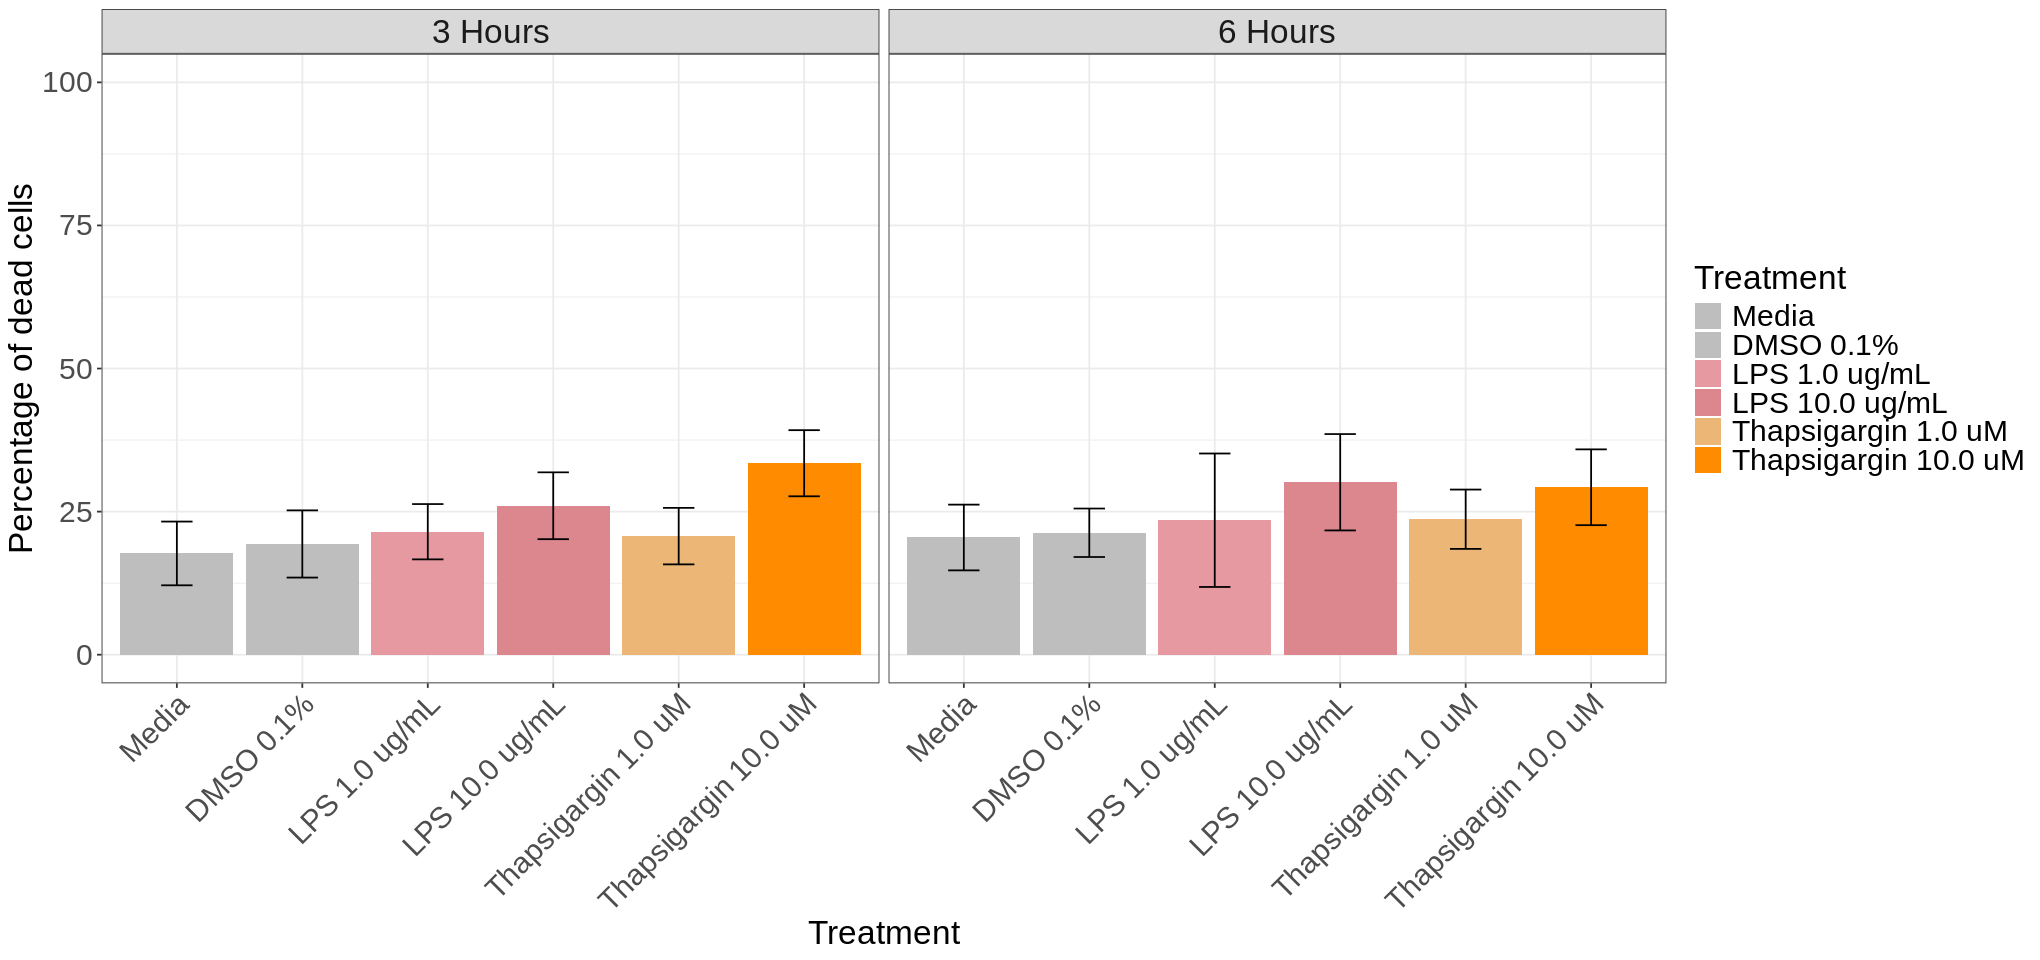

In [5]:
# plot the death curve data 
width <- 17
height <- 8
options(repr.plot.width = width, repr.plot.height = height)
death_curve_plot <- (
    ggplot(death_df_agg, aes(x = treatment, y = mean_death, fill = treatment))
    + geom_bar(stat = "identity", position = "dodge")
    + geom_errorbar(aes(ymin = mean_death - sd_death, ymax = mean_death + sd_death), width = 0.25, position = position_dodge(0.9))
    + theme_bw()
    + figure_theme
    + ylim(0, 100)
    + labs(
           x = "Treatment",
           y = "Percentage of dead cells")
    + facet_grid(~time)
    + theme(
        axis.text.x = element_text(size = 18, angle = 45, hjust = 1),
        axis.text.y = element_text(size = 18),
        axis.title = element_text(size = 20),
        strip.text = element_text(size = 20),
        legend.text = element_text(size = 18),
        legend.title = element_text(size = 20),
        # legend.position = "none"
    )
    + scale_fill_manual(
        name = "Treatment",
        labels = c(
            'Media',
            'DMSO 0.1%',
            'LPS 1.0 ug/mL',
            'LPS 10.0 ug/mL',
            'Thapsigargin 1.0 uM',
            'Thapsigargin 10.0 uM'
        ),
        values = death_curve_colors)
)
# save the plot
ggsave(oputput_figure_path, plot = death_curve_plot, width = width, height = height, units = "in")
death_curve_plot